In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
df = pd.read_excel("DS Internship - Modeling - Data.xlsx")

In [3]:
"""      
Build a linear regression model to predict the sales of the stores and identify key drivers of sales.
"""
df.dtypes

Store ID                           int64
Pop class                         object
Sales                            float64
Centre Type                       object
Climate                           object
Total Store Sq Ft                float64
Sales Floor Sq Ft                float64
Girls Sq Ft                      float64
Guys Sq Ft                       float64
Accessories Sq Ft                float64
Guys Segmentation                 object
Girls Segmentation                object
ChangeMade                        object
ChangeDate                        object
Population Est CrYr                int64
Transient Pop Est                  int64
Seasonal Pop Est                   int64
Sex Males CrYr                     int64
Sex Females CrYr                   int64
Age Average CrYr                 float64
Unemployment Rate                float64
Average Household Income CrYr      int64
Householder under 25 years:        int64
Householder 25 to 44 years:        int64
Family Inc: Aggr

In [4]:
"""   
I am going over these columns to look at the values, cleaning them as necessary and deciding how to encode them
"""

df['Pop class'].value_counts() # Pop Class could be encoded as -1 for urban, 0 for suburban, 1 for rural

df['Centre Type'].value_counts() # Onehot encoding

df['Climate'].value_counts() # Hot, twarm, moderate, cold, frigid encoded as 0, 1, 2, 3, 4

df['Guys Segmentation'].value_counts() # change 'On trend' and 'On Trend' to be the same class. then encode as a boolean
df['Guys Segmentation'] = df['Guys Segmentation'].apply(lambda x: x.lower().strip())

df['Girls Segmentation'].value_counts() # boolean encoding 

df['ChangeMade'].value_counts() # onehot encoding

df['ChangeDate'] # datetime encoding


0      2011-10-06 00:00:00
1      2016-11-09 00:00:00
2      2019-09-25 00:00:00
3      2012-09-27 00:00:00
4      2007-03-13 00:00:00
              ...         
686                    NaN
687                    NaN
688                    NaN
689                    NaN
690                    NaN
Name: ChangeDate, Length: 691, dtype: object

In [5]:
"""      
Here I actually do the encoding of the columns
"""

df['Pop class'] = df['Pop class'].apply(lambda x: -1 if x == 'Urban' else 0 if x == 'Suburban' else 1)

df = pd.get_dummies(df, columns=['Centre Type'])

df['Climate'] = df['Climate'].apply(lambda x: 0 if x == 'Hot' else 1 if x == 'Warm' else 2 if x == 'Moderate' else 3 if x == 'Cold' else 4)

df['Guys Segmentation'] = df['Guys Segmentation'].apply(lambda x: 1 if x == 'on trend' else 0)

df['Girls Segmentation'] = df['Girls Segmentation'].apply(lambda x: 1 if x == 'on trend' else 0)

df = pd.get_dummies(df, columns=['ChangeMade'])

df['ChangeDate'] = pd.to_datetime(df['ChangeDate'])

In [6]:
"""      
Here I note that the data for changedate has been encoded as datetime, but since this is a linear regression model, I will need to encode it as a number. I will do this by encoding it as year, month, and day"""
df['ChangeYear'] = df['ChangeDate'].dt.year
df['ChangeMonth'] = df['ChangeDate'].dt.month
df['ChangeDay'] = df['ChangeDate'].dt.day
df.drop(columns=['ChangeDate'], inplace=True)

In [7]:
"""       
We need to now remove na values from the dataset. We will do this by removing rows with na values.

It also seems like there are too many na values in the time columns. This is not the kind of data, I can otherwise average, so I am choosing to remove these columns.
"""
df.isna().sum()

df.drop(columns=['ChangeYear', 'ChangeMonth', 'ChangeDay'], inplace=True)

df.dropna(inplace=True)


In [8]:
df.drop(columns=['Population Est CrYr'], inplace=True)

In [9]:
df.columns

Index(['Store ID', 'Pop class', 'Sales', 'Climate', 'Total Store Sq Ft',
       'Sales Floor Sq Ft', 'Girls Sq Ft', 'Guys Sq Ft', 'Accessories Sq Ft',
       'Guys Segmentation', 'Girls Segmentation', 'Transient Pop Est',
       'Seasonal Pop Est', 'Sex Males CrYr', 'Sex Females CrYr',
       'Age Average CrYr', 'Unemployment Rate',
       'Average Household Income CrYr', 'Householder under 25 years:',
       'Householder 25 to 44 years:', 'Family Inc: Aggregate Average',
       'Per Capita Income CrYr', 'Wealth: Average Household',
       'Poverty: In poverty', 'Male 14 to 35 CrYr', 'Female 14 to 35 CrYr',
       'Total Pop 14 to 35 CrYr', 'Under 25 Low Income', 'Under 25 Med Income',
       'Under 25 High Income', '25 to 44 Low Income', '25 to 44 Med Income',
       '25 to 44 High Income', 'Centre Type_Mall', 'Centre Type_Outlet',
       'Centre Type_Strip', 'ChangeMade_expansion', 'ChangeMade_no change',
       'ChangeMade_relocation', 'ChangeMade_remodel'],
      dtype='object')

In [10]:
df.drop(columns=['Store ID', 'Sex Males CrYr', 'Sex Females CrYr', 'Householder under 25 years:',
                 'Householder 25 to 44 years:', 'Family Inc: Aggregate Average',
                 'Wealth: Average Household','Poverty: In poverty', 'Male 14 to 35 CrYr', 
                 'Female 14 to 35 CrYr', 'Total Pop 14 to 35 CrYr', 'Under 25 Low Income', 
                 'Under 25 Med Income', 'Under 25 High Income', '25 to 44 Low Income',
                 '25 to 44 Med Income', 'Sales Floor Sq Ft'], inplace=True)

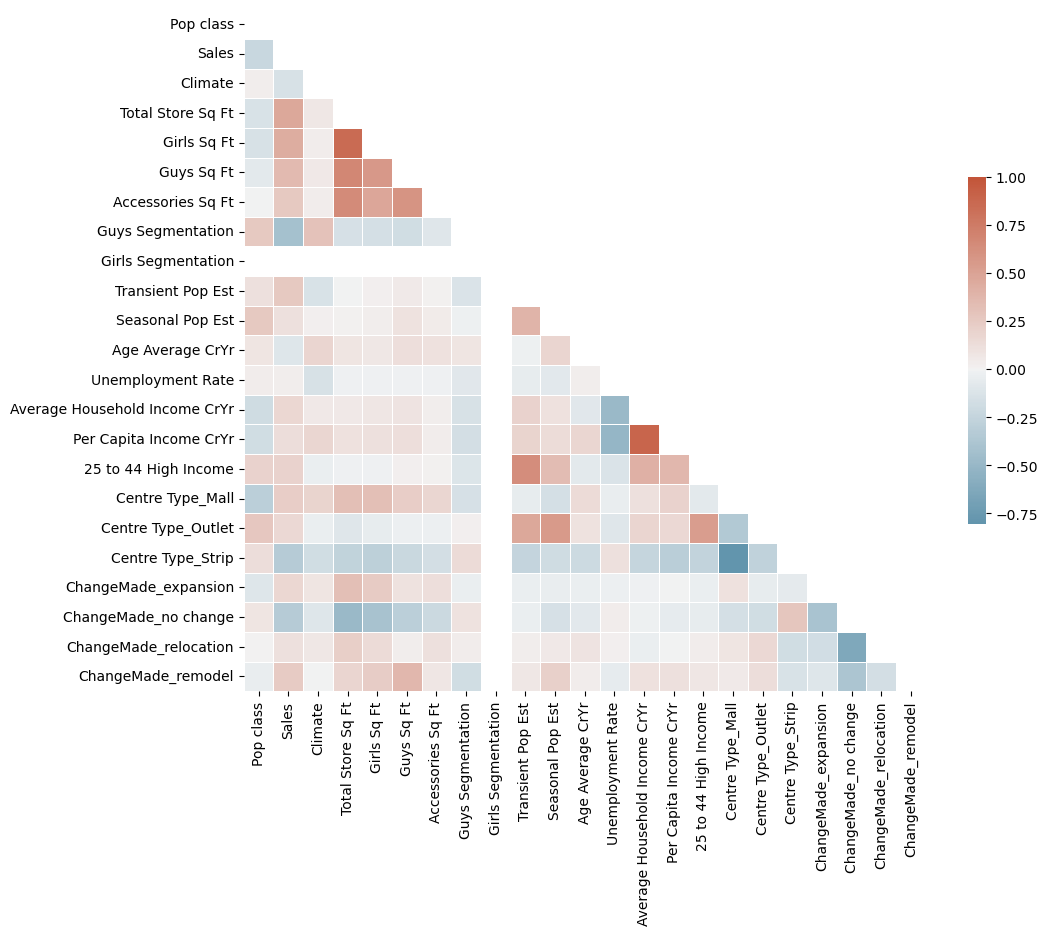

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

"""            
Here I add a mask to remove duplicates and the diagonal which we know trivially will be 1 in the correlation matrix. 

I also add a color map to make it easier to see the values."""
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))


cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, mask=mask, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()


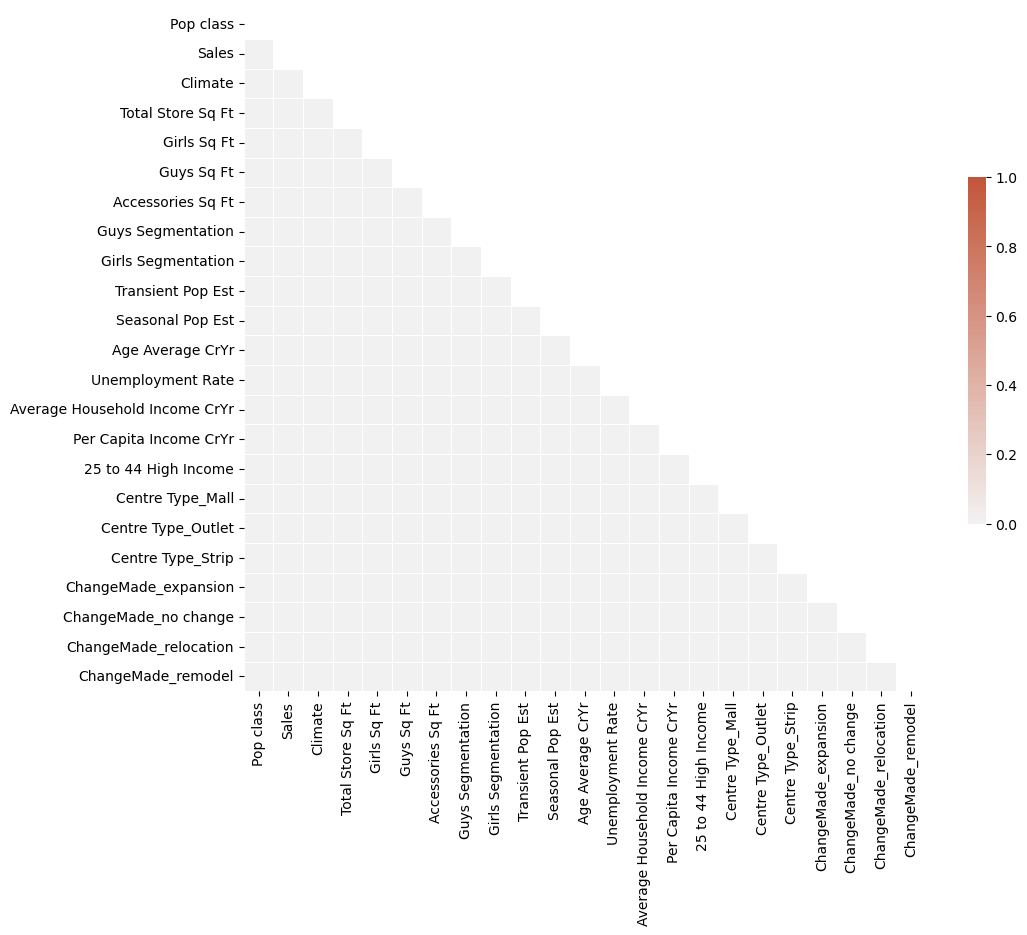

In [12]:
"""       
Now I will add a threshold to check for colinearity, since linear regression assumes that the features are independent

Here I use a conservative threshold of 0.9, but this can be adjusted as necessary.
"""
f, ax = plt.subplots(figsize=(11, 9))


sns.heatmap(np.abs(corr)>0.9, cmap=cmap, mask=mask, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [13]:
import sklearn.linear_model

X = df.drop(columns='Sales')
y = df['Sales']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=13)

model = sklearn.linear_model.LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

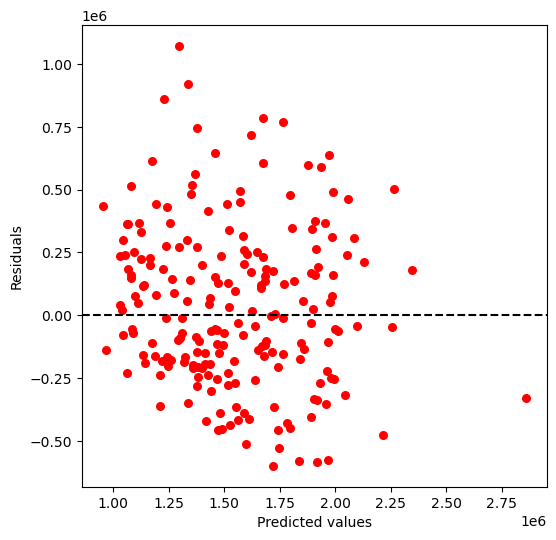

In [14]:
"""       
As we can see below, the residuals seem to be normally distributed, which confirms our assumption 
for linear regression that the residuals are normally distributed since error must be normally distributed.
"""

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred


fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test_pred, residuals_test, color='red', s=30)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')

plt.show()



In [21]:
pred = model.predict(X_test)


"""       
Here are some more metrics I have included in addition to MAPE

I think in this situation, all can be used as metrics for performance, but MAPE probably is most intuitive for this situation.
"""

print(f"MAPE is: {sklearn.metrics.mean_absolute_percentage_error(y_test, pred)}")
print(f"RMSE is: {sklearn.metrics.mean_squared_error(y_test, pred, squared=False)}")
print(f"R2 is: {sklearn.metrics.r2_score(y_test, pred)}")



MAPE is: 0.1675998240502054
RMSE is: 323028.67742742796
R2 is: 0.42573300859783636


c:\Users\Hrsh Venket\miniconda3\envs\tiger-analytics\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


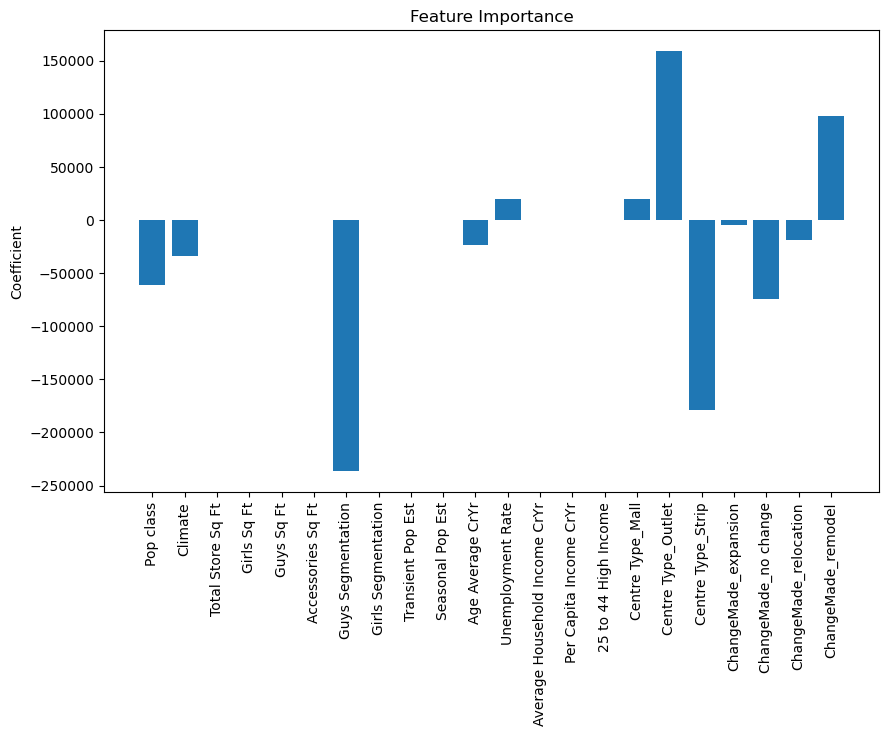

In [16]:
import matplotlib.pyplot as plt

feature_names = df.drop(columns='Sales').columns
coefficients = model.coef_

plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients)
plt.ylabel('Coefficient')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()


In [29]:
X_scaled

array([[ 1.01112408,  1.95449124, -1.24594796, ..., -1.20631552,
         1.89665902, -0.31825489],
       [-0.57020011,  0.18939368,  1.17960248, ..., -1.20631552,
        -0.5272429 ,  3.14213556],
       [-0.57020011, -1.57570388, -1.35641857, ..., -1.20631552,
         1.89665902, -0.31825489],
       ...,
       [ 2.59244828,  0.18939368, -0.88251565, ...,  0.82897052,
        -0.5272429 , -0.31825489],
       [-0.57020011, -0.6931551 , -0.61034167, ...,  0.82897052,
        -0.5272429 , -0.31825489],
       [-0.57020011,  0.18939368,  0.3798913 , ...,  0.82897052,
        -0.5272429 , -0.31825489]])

MAPE is: 0.16759982405021887
RMSE is: 323028.6774274341
R2 is: 0.4257330085978146


c:\Users\Hrsh Venket\miniconda3\envs\tiger-analytics\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


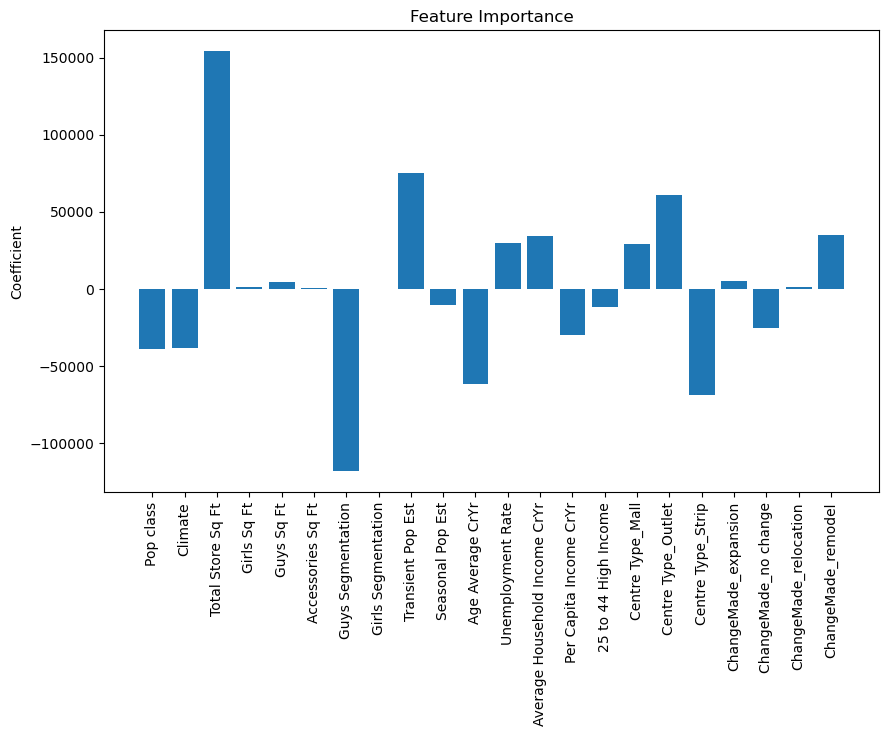

In [28]:
"""
1. Go over assignment 4 and try to make my intuition reflect in model coefficents

I went over the coefficients. We assume with LR that the data is normally distributed.
However, with the data, each parameter has a different scale (both stddev and mean)."""

# regularise the input data then split it into train and test
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = df['Sales']

X_train1, X_test1, y_train1, y_test1 = sklearn.model_selection.train_test_split(X_scaled, y, test_size=0.3, random_state=13)

model = sklearn.linear_model.LinearRegression()

model.fit(X_train1, y_train1)

pred = model.predict(X_test1)

print(f"MAPE is: {sklearn.metrics.mean_absolute_percentage_error(y_test1, pred)}")
print(f"RMSE is: {sklearn.metrics.mean_squared_error(y_test1, pred, squared=False)}")
print(f"R2 is: {sklearn.metrics.r2_score(y_test1, pred)}")

feature_names = df.drop(columns='Sales').columns
coefficients = model.coef_

plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients)
plt.ylabel('Coefficient')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()


MAPE is: 0.17675914980846089
RMSE is: 353504.21000451286
R2 is: 0.31226539722780466


c:\Users\Hrsh Venket\miniconda3\envs\tiger-analytics\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


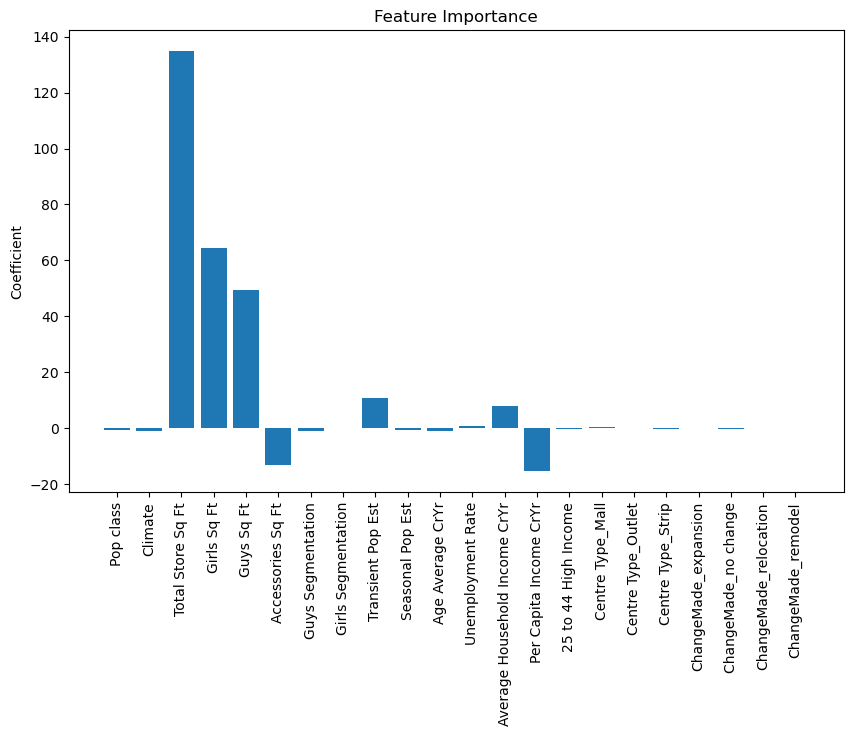

In [24]:
"""      
Here I show the results of Bayesian Ridge regression.

As we see it performs worse on the given dataset, but it is a more robust model in general, so it is worth using.

This means that across datasets, it is likely to perform better"""

bayesian_ridge = sklearn.linear_model.BayesianRidge()
bayesian_ridge.fit(X_train, y_train)

pred = bayesian_ridge.predict(X_test)

print(f"MAPE is: {sklearn.metrics.mean_absolute_percentage_error(y_test, pred)}")
print(f"RMSE is: {sklearn.metrics.mean_squared_error(y_test, pred, squared=False)}")
print(f"R2 is: {sklearn.metrics.r2_score(y_test, pred)}")

feature_names = df.drop(columns='Sales').columns
coefficients = bayesian_ridge.coef_

plt.figure(figsize=(10, 6))
plt.bar(feature_names, coefficients)
plt.ylabel('Coefficient')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()
